# Bloom Filters

## Task 1
***Give an overview of the types of operations that a Bloom filter supports, and where Bloom filters might be useful.***

Bloom filter is a probabilistic data structure that is used to test whether an element is in the hash table.

Operations that Bloom filter supports:
1. ***Element look-up***<br/>
    **a.** If the searched element is **not** in the list, the filter will return the definite answer. The look-up complexity is always $O(1)$, which is much faster than an unsuccessful check of an element in open-addressing $O(\frac{1}{1 - \alpha})$ or chained hash tables $O(1 + \alpha)$ where $\alpha$ is the load factor (number of elements expected to be inserted or are already in the list and the number of cells in the hash table.<br/>
    **b.** If element is in the list, we might encounter false positives when the filter thinks the element is there but actually its hash footprint is created by other elements. Runtime still always take constant time.<br/>

2. ***Insertion***<br/>
    **a.** An incoming element is hashed using k hash functions. Then we perform [1 **OR** with the values in the positions of the values the hash functions produced for the element]. <br/>
    
3. ***Deletion***<br/>
    **a.** Original Bloom filter does not support deletion but we can enable deletion by adding counting at each hash table cell. Instead of storing 0 or 1 bits, we can make it a byte-array and add 1 every time the hash produces the cell position as value. 
    
    
    
Bloom filters are an efficient way to filter queries when accessing information in large hash tables. For example, a website that stores logins of users could run the user's input login through a Bloom filter to determine whether such user even exists in a very short time. If it does not, we can return an error in a constant time because we don't have a load factor that would affect the lookup time. If the element probably exist, then it is worth spending time to search for it in the actual hash table and check the password it comes with.<br/>
   
## Task 2
***Implement a Bloom filter.***

In [65]:
from random import randint, seed
import math

class BloomFilter:
# Private instances
    __hash_params = []
    __elem_cnt = 0
    __bit_cnt = 0
    __seed = None
    
    def __generate_hash_f(self):
        if self.__seed != None:
            seed(self.__seed)
        else:
            seed(0)
            
        self.__generate_large_prime_num()
        p = self.__prime_base
        self.__hash_params = []
        
        for i in range(self.__num_hash_f):
            self.__hash_params.append((randint(1, p - 1), randint(0, p - 1)))
        
    def __hash(self, elem):
        hash_vals = list()
        p = self.__prime_base
        
        for params in self.__hash_params:
            (a, b) = params
            hash_value = ((a * elem + b) % p) % self.__arr_cp
            hash_vals.append(hash_value)
        
        return hash_vals
    
    def __generate_large_prime_num(self):
        self.__prime_base = 274876858367 # GENERATE PROPERLY, DUUUUDE
    
    
# Formatting
    def __str__(self):
        out = '\n\033[1mBitmap\033[0m\n'
        out += ' '.join(map(lambda x: str(x), self.__hash_map))
        out += '\n\033[1mSome statistics\033[0m'
        out += '\nBitmap capacity: ' + str(self.__arr_cp)
        out += '\nHash functions used: ' + str(self.__num_hash_f)
        out += '\nBit count: ' + str(self.__bit_cnt)
        out += '\nElement count: ' + str(self.__elem_cnt) + '\n'
        return out
    
        
# Public instances
    def __init__(self, arr_cp, fp_rate=0.01, num_hash_f=0, rand_seed=None):
        self.__arr_cp = arr_cp
        self.__hash_map = [0] * arr_cp
        
        if num_hash_f != 0:
            self.__num_hash_f = num_hash_f
        else:
            self.__num_hash_f = math.ceil(-math.log(fp_rate))

        if rand_seed != None:
            self.__seed = rand_seed
        self.__generate_hash_f()
        
    def add(self, elem):
        if not self.search(elem):
            for idx in self.__hash(elem):
                self.__hash_map[idx] = 1
            self.__elem_cnt += 1
            self.__bit_cnt = sum(self.__hash_map)
    
    def search(self, elem):
        maybe_in_list = True
        for idx in self.__hash(elem):
            if self.__hash_map[idx] != 1:
                maybe_in_list = False
                
        return maybe_in_list

### Reference

**Containers**:
- hash_params - tuples of a and b coefficients for universal hash functions
- hash_map - byte-array storing the key counters

**Size**:
- arr_cp - capacity of the hash table
- arr_sz - current load level (number of inserted elements)
- num_hash_f - number of hash functions

**Counters**:
- elem_cnt - count of inserted elements to resize when overfilled
- bit_cnt - count of number of bits in the hash map

**Constants**:
- prime_base - the value of p for transforming $U \to Z_p \to Z_{arr\_cp}$

**Misc**:
- seed - seed to independently generate hash functions

### Test code

In [66]:
bloom_filter = BloomFilter(arr_cp=100)
bloom_filter.add(56)
bloom_filter.add(54)
bloom_filter.add(71)
bloom_filter.add(91)
bloom_filter.add(82)
bloom_filter.add(49)
bloom_filter.add(82)
print(bloom_filter)

bloom_filter_2 = BloomFilter(arr_cp=100)
bloom_filter_2.add(49)
print(bloom_filter_2.search(49))


Bitmap
0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
Some statistics
Bitmap capacity: 100
Hash functions used: 5
Bit count: 28
Element count: 6

True


## Task 3
***Give a description of the hash functions that your implementation uses.***

I generate hash functions from the universal set of hash functions to ensure that they will generate values uniformly on a restricted domain. This would mean that for two different values $x, y ∈ U, x \neq y$, the probability that $h(x) = h(y) ∈ Z_{arr\_cp}$ would be less or equal to $\frac{1}{arr\_cp}$.

The reason I use a subset of universal hash functions is to reduce the rate of false positives by not "overfilling" some particular cells in the hash map. If we reuse the same set of cells too often, when we search for a new value, its hash will likely fall into those cells and return a false positive.

## Task 4
***Provide an analysis of how your implementation scales in terms of:***<br/>
Let's use the following notation:
- $k$ is the number of hash functions the Bloom filter uses
- $m$ is the total number of bits allocated to store the elements
- $n$ is the number of elements inserted into the hash table
- $p_{fp}$ is the probability of a false-positive lookup result
- $X$ is the number of bits set to one

    *1) memory size as a function of the false positive rate*<br/>
    Approximation of false positive rate:
    $$ (1 - e^{-\frac{kn}{m}})^k = p_{fp} $$
    $$ 1 - e^{-\frac{kn}{m}} = \sqrt[k]{p_{fp}} $$
    $$ (e^{-kn})^{1/m} = 1 - \sqrt[k]{p_{fp}} $$
    $$ \dfrac{1}{m} = log_{e^{-kn}}(1 - \sqrt[k]{p_{fp}}) $$
    $$ m = log_{1 - \sqrt[k]{p_{fp}}}(e^{-kn}) $$
    $$ m = log_{1 - \sqrt[k]{p_{fp}}}(e^{⌈ln(p_{fp})⌉n}) $$
    $$ m = \Theta(log_{1 - \sqrt[k]{p_{fp}}}(e^{n}logp_{fp})) $$
    
   *2) memory size as a function of the number of items stored*<br/>
    Using the formula for estimated number of inserted items derived in Swamidass & Baldi (2007):
    $$ n^* = -\dfrac{m}{k}ln(1 - \dfrac{X}{m}) $$
    $$ m = -\dfrac{kn^*}{ln(1 - \frac{X}{m})}  $$
    $$ m = \Theta(-\dfrac{kn^*}{ln(1 - \frac{X}{m})})  $$
    
   *3) access time as a function of the false positive rate*<br/>
   Access time depends on the number of hash function we use:
    $$ k = ⌈-ln(p_{fp})⌉ $$
    $$ k = \Theta(-logp_{fp}) $$
    
   *4) access time as a function of the number of items stored*<br/>
   Access time does not depend on the number of items stored because in any case we need to check $k$ cells.
    $$ k = \Theta(1 + 0n) $$
    
## Task 5
***Produce a plot to show that your implementation’s false positive rate matches the theoretically expected rate.***

In [147]:
import time
from sys import stdout

### False positive rate and memory size
NUM_BL_FILT = 10 # use several bloom filters per capacity to reduce bias
MIN_ARR_CP = 20
MAX_ARR_CP = 2000
NUM_ELEM = 20
U = list(range(1000)) # universe of possible keys

'''
Bloom filters initialization
'''
print("\n\033[1mInitializing bloom filters\033[0m")
start = time.time()
num_cps = MAX_ARR_CP - MIN_ARR_CP + 1

# matrix of size num_capacities * NUM_BL_FILT * NUM_ELEM
# to store actual elements in the set
hash_map = [None] * num_cps

# matrix of size num_capacities * NUM_BL_FILT to store all bloom filters
bl_filts = [None] * num_cps

for row in range(num_cps):
    bl_filts[row] = []
    hash_map[row] = []
    for bl_id in range(NUM_BL_FILT):
        stdout.write("\rProgress: row = {0} out of {1}, creating filter bl_id = {2} out of {3}. Time elapsed: {4}s".format(row, num_cps - 1, bl_id, NUM_BL_FILT - 1, int(time.time() - start)))
        obj_init = BloomFilter(arr_cp=row + MIN_ARR_CP, rand_seed=bl_id)
        bl_filts[row].append(obj_init)
        hash_map[row].append(set())
        
stdout.write("\nDone!\n\n")    
        
'''
Random items insertion
'''
print("\033[1mFilling the bloom filters\033[0m")
start = time.time()

for row in range(num_cps):
    for bl_id in range(NUM_BL_FILT):
        stdout.write("\rProgress: row = {0} out of {1}, filling filter bl_id = {2} out of {3}. Time elapsed: {4}s".format(row, num_cps - 1, bl_id, NUM_BL_FILT - 1, int(time.time() - start)))
        for _ in range(NUM_ELEM):
            val_to_add = U[randint(1, len(U) - 1)]
            bl_filts[row][bl_id].add(val_to_add)
            hash_map[row][bl_id].add(val_to_add)
stdout.write("\nDone!\n")    

'''
Items lookup false positives
'''
print("\n\033[1mPerforming lookup tests\033[0m")
start = time.time()
fp_per_cp = [0] * num_cps # array to store fp rates

for row in range(num_cps):
    fp_cnt = 0 # false positive count
    tn_cnt = 0 # true negative count
    for bl_id in range(NUM_BL_FILT):
        stdout.write("\rProgress: row = {0} out of {1}, testing filter bl_id = {2} out of {3}. Time elapsed: {4}s".format(row, num_cps - 1, bl_id, NUM_BL_FILT - 1, int(time.time() - start)))
        for key in U:
            key_exists = key in hash_map[row][bl_id]
            bl_filt_pass = bl_filts[row][bl_id].search(key)
            
            if (not key_exists) and (not bl_filt_pass):
                tn_cnt += 1
            elif (not key_exists) and bl_filt_pass:
                fp_cnt += 1
    fp_per_cp[row] = fp_cnt / (fp_cnt + tn_cnt)
stdout.write("\nDone!\n")


Initializing bloom filters
Progress: row = 1980 out of 1980, creating filter bl_id = 9 out of 9. Time elapsed: 2s
Done!

Filling the bloom filters
Progress: row = 1980 out of 1980, filling filter bl_id = 9 out of 9. Time elapsed: 9s
Done!

Performing lookup tests
Progress: row = 1980 out of 1980, testing filter bl_id = 9 out of 9. Time elapsed: 87s
Done!


In [150]:
'''
Theoretical false positive rates using formula in 4.1
'''
arr_cps = range(MIN_ARR_CP, MIN_ARR_CP + num_cps)
k = math.ceil(-math.log(0.01))
fp_per_cp_theor = list(map(lambda arr_cp: (1 - math.e**(-k * NUM_ELEM / arr_cp))**k, arr_cps))

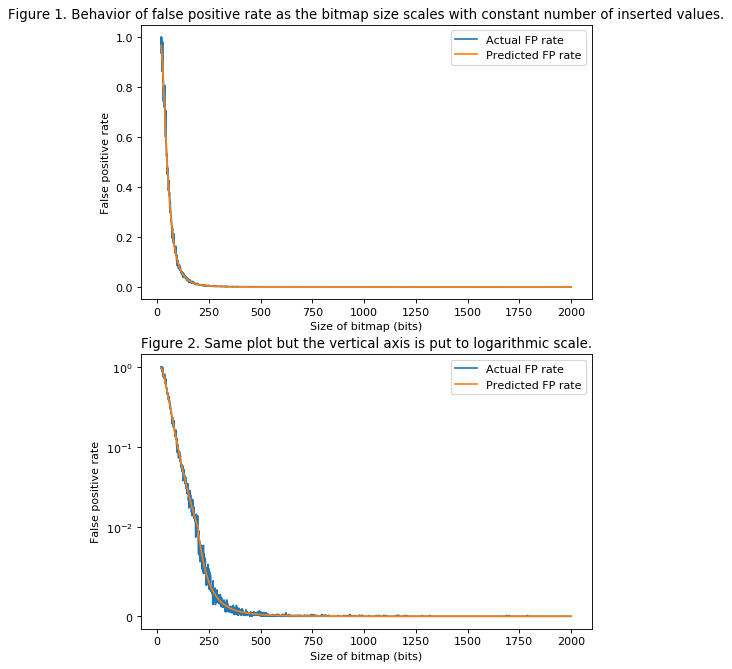

In [155]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(221)
real, = plt.plot(arr_cps, fp_per_cp, label="Actual FP rate")
theor, = plt.plot(arr_cps, fp_per_cp_theor, label="Predicted FP rate")
plt.legend(handles=[real, theor])

plt.xlabel("Size of bitmap (bits)")
plt.ylabel("False positive rate")
plt.title("Figure 1. Behavior of false positive rate as the bitmap size scales with constant number of inserted values.")

plt.subplot(223)
real, = plt.plot(arr_cps, fp_per_cp, label="Actual FP rate")
# real, = plt.plot(arr_cps, np.poly1d(np.polyfit(arr_cps, fp_per_cp, 10))(arr_cps), label="Actual FP rate")
theor, = plt.plot(arr_cps, fp_per_cp_theor, label="Predicted FP rate")
plt.yscale('symlog', linthreshy=0.01)
plt.legend(handles=[real, theor])

plt.xlabel("Size of bitmap (bits)")
plt.ylabel("False positive rate")
plt.title("Figure 2. Same plot but the vertical axis is put to logarithmic scale.")

plt.show()

As we can see, the plots generally 